In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import sqrt
from math import exp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Settings

In [2]:
C = 0.1
R = 1

# Code

In [13]:
# parameters
r_min = 0.2
r_max = 2.0
c = 1.5
a = 0.8
b = 1.4
count1 = 900
count2 = count1 * 3
h1 = (r_max - r_min) / count1
h2 = (r_max - r_min) / count2
tau1 = C * h1 / c
tau2 = C * h2 / c

timeBegin, timeEnd = 1.2, 1.8

In [14]:
def r(i, h):
    return r_min + (i - 0.5)*h
r1 = [r(i, h1) for i in range(count1 + 2)]
r2 = [r(i, h2) for i in range(count2 + 2)]

In [15]:
analSol = lambda t, r: r ** ((1 - R) / 2) * U(c * t - r)

In [16]:
def gen_next(u, u_prev, h, tau, r):
    u_next = [0 for _ in range(len(u))]
    for i in range(2, len(u) - 2):
        u_next[i] = 2 * u[i] - u_prev[i] + (tau**2 * c**2) / h**2 * (
            -5/2*u[i] + 4/3*u[i + 1] + 4/3*u[i-1] - 1/12 * u[i + 2] - 1/12 * u[i - 2]
        )
    u_next[0] = u_next[1] = u_next[2]
    u_next[-1] = u_next[-2] = u_next[-3]
    return u_next

In [17]:
def U(r):
    if a < r < b:
        return exp((-4*(2*r - (a + b))**2) / ((b - a)**2 - (2*r - (a + b))**2))
    return 0

In [18]:
def calc_C(u1, u2):
    if len(u1) == count1 + 2:
        u1_ = u1[1:-1]
        u2_ = u2[1:-1]
        ans = [abs(u1_[i] - u2_[i]) for i in range(len(u2_))]
    else:
        u1_ = u1[2:-2:3]
        u2_ = u2[1:-1]
        ans = [abs(u1_[i] - u2_[i]) for i in range(len(u1_))]
    return max(ans)

In [19]:
def calc_L2(u1, u2):
    if len(u1) == count1 + 2:
        u1_ = u1[1:-1]
        u2_ = u2[1:-1]
    else:
        u1_ = u1[2:-2:3]
        u2_ = u2[1:-1]
    ans = [(abs(u1_[i] - u2_[i]))**2 for i in range(len(u1_))]
    return sqrt(sum(ans))

In [20]:
t = timeBegin
u01 = [analSol(timeBegin, r(i, h1)) for i in range(count1 + 2)]
v01 = [analSol(timeBegin, r(i, h1)) for i in range(count1 + 2)]

u02 = [analSol(timeBegin, r(i, h2)) for i in range(count2 + 2)]
v02 = [analSol(timeBegin, r(i, h2)) for i in range(count2 + 2)]


u_next1 = [analSol(timeBegin + tau1, r(i, h1)) for i in range(count1 + 2)]
v01_next = [analSol(timeBegin + tau1/2, r(i, h1)) for i in range(count1 + 2)]
y2 = gen_next(v01_next, v01, h1, tau1/2, r1)
v01_next, v01 = y2, v01_next

u_next2 = [analSol(timeBegin + tau2, r(i, h2)) for i in range(count2 + 2)]
v02_next = [analSol(timeBegin + tau2/2, r(i, h2)) for i in range(count2 + 2)]
y2 = gen_next(v02_next, v02, h2, tau2/2, r2)
v02_next, v02 = y2, v02_next
for i in range(2):
    y2 = gen_next(u_next2, u02, h2, tau2, r2)
    u_next2, u02 = y2, u_next2
    for i in range(2):
        y2 = gen_next(v02_next, v02, h2, tau2/2, r2)
        v02_next, v02 = y2, v02_next

In [21]:
norm_c = []
norm_L2 = []
time = []
t = timeBegin + tau1
with tqdm(total=int((timeEnd - timeBegin)/tau1)) as pbar:
    while t < timeEnd:
        y1 = gen_next(u_next1, u01, h1, tau1, r1)
        u_next1, u01 = y1, u_next1
        for i in range(2):
            y2 = gen_next(v01_next, v01, h1, tau1/2, r1)
            v01_next, v01 = y2, v01_next
        
        for i in range(3):
            y3 = gen_next(u_next2, u02, h2, tau2, r2)
            u_next2, u02 = y3, u_next2
            for i in range(2):
                y4 = gen_next(v02_next, v02, h2, tau2/2, r2)
                v02_next, v02 = y4, v02_next

        analit_sol = [analSol(t + tau1, r(i, h1)) for i in range(count1 + 2)]
        
        w1 = [1/3*(4*v01_next[i] - u_next1[i]) for i in range(len(u_next1))]
        w2 = [1/3*(4*v02_next[i] - u_next2[i]) for i in range(len(u_next2))]
        
        norm_c.append(calc_C(w1, analit_sol)  / calc_C(w2, analit_sol))
        norm_L2.append(calc_L2(w1, analit_sol) / calc_L2(w2, analit_sol))
        time.append(t + tau1)
        t += tau1
        pbar.update(1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:43<00:00, 104.20it/s]


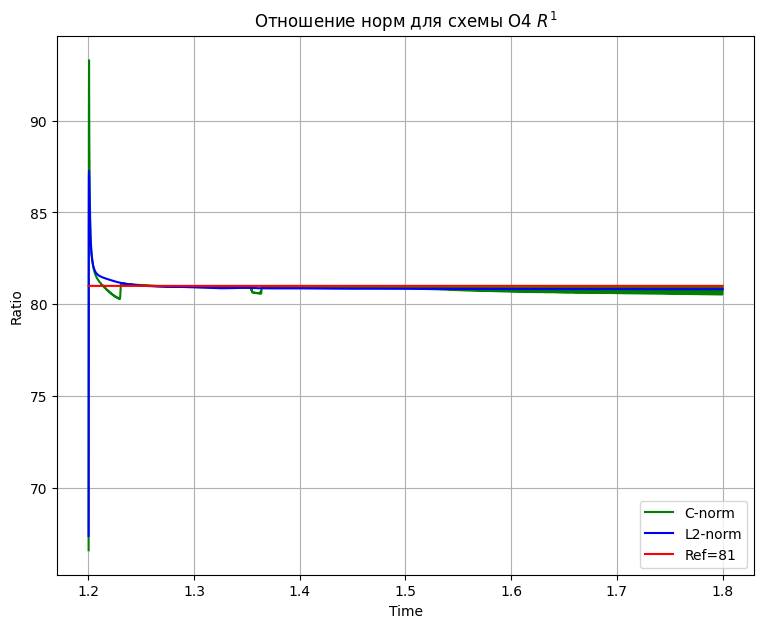

In [24]:
fig, ax = plt.subplots(figsize = (9, 7))
ax.plot(time, norm_c, 'g')
ax.plot(time, norm_L2, 'b')
ax.plot(time, [81 for _ in range(len(time))], 'r')
ax.set_title("Отношение норм для схемы O4 $R^1$")
ax.grid()
ax.legend(['C-norm', 'L2-norm', 'Ref=81'], loc=4)
ax.set_xlabel('Time')
ax.set_ylabel('Ratio')

plt.show()